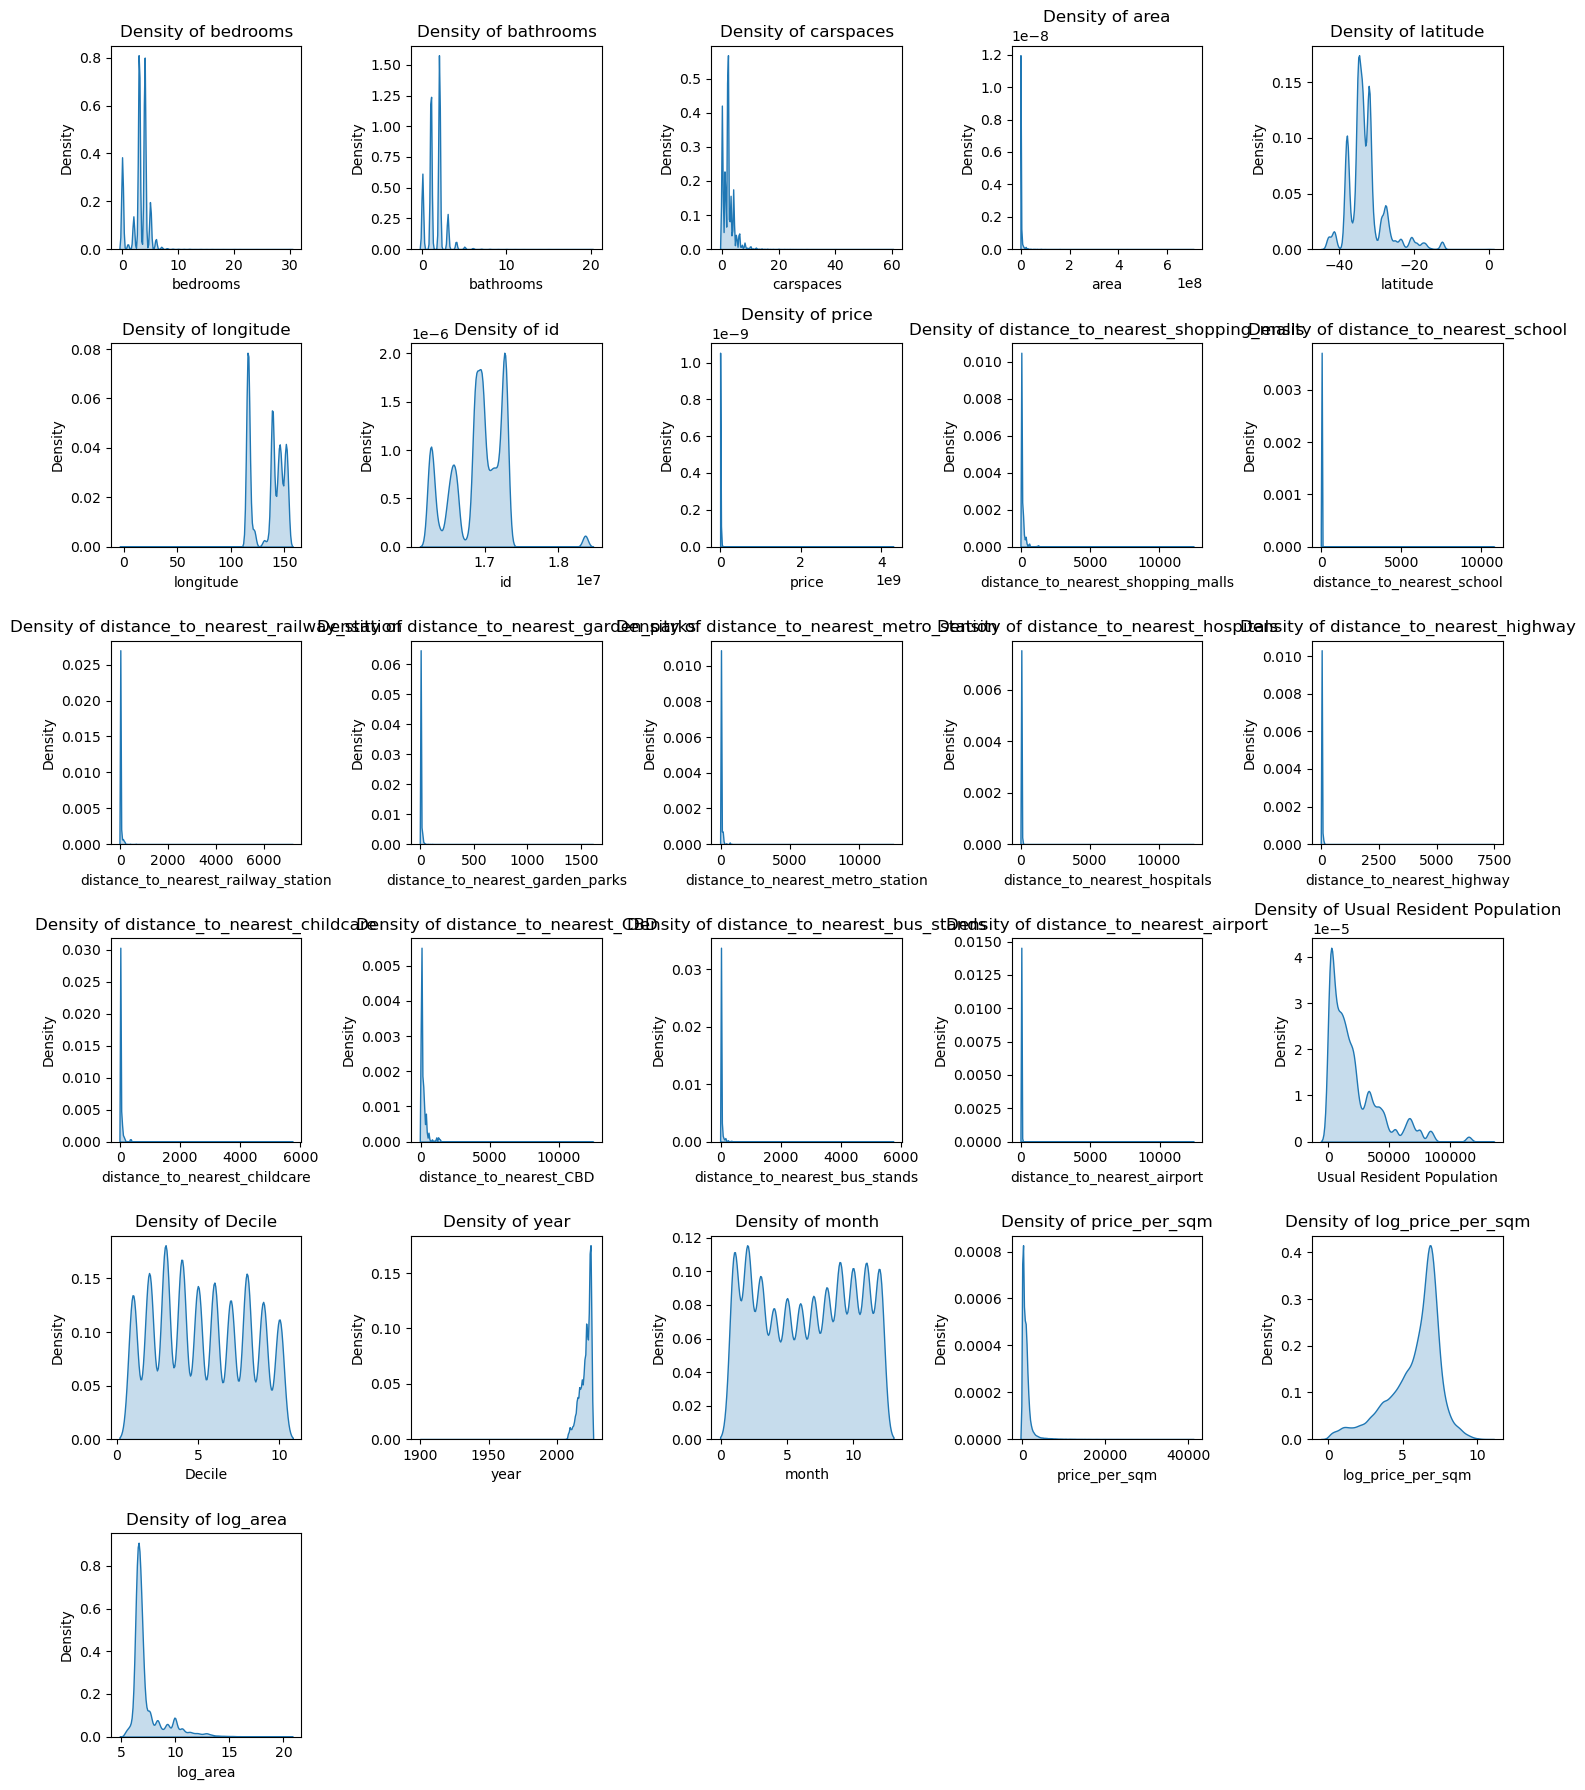

In [4]:
import math

# Count the number of numerical columns
num_cols = df.select_dtypes(include=["number"]).columns
num_features = len(num_cols)

# Determine subplot layout dynamically
rows = math.ceil(num_features / 5)  # 5 plots per row
cols = min(num_features, 5)  # Max 5 columns

# Plot Density (KDE) for each numerical variable
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.kdeplot(df[col], ax=axes[i], fill=True)
    axes[i].set_title(f"Density of {col}")

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans

# Load the dataset
file_path = "Train_data.csv"
df = pd.read_csv(file_path)

# Drop unnecessary columns
df.drop(columns=["property_id", "street", "streetnumber", "Score", "postcode"], inplace=True, errors='ignore')

# Drop rows where price or area is missing
df.dropna(subset=["price", "area"], inplace=True)

# Convert 'date' to datetime format and extract year and month
df["date"] = pd.to_datetime(df["date"], errors='coerce')
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df.drop(columns=["date"], inplace=True)

# Feature Engineering
df["price_per_sqm"] = df["price"] / df["area"]
df["log_price_per_sqm"] = np.log1p(df["price_per_sqm"])
df["log_area"] = np.log1p(df["area"])

# Split before target encoding to prevent leakage
X = df.copy()
y = df["log_price_per_sqm"]
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reattach the target temporarily for encoding
X_train_full["log_price_per_sqm"] = y_train_full

# Cross-validated smoothed target encoding for 'suburb'
global_mean = X_train_full["price"].mean()
alpha = 10
kf = KFold(n_splits=5, shuffle=True, random_state=42)

suburb_encoded = pd.Series(index=X_train_full.index, dtype=float)

for train_idx, val_idx in kf.split(X_train_full):
    train_fold = X_train_full.iloc[train_idx]
    val_fold = X_train_full.iloc[val_idx]

    # Compute smoothed mean price in this fold
    fold_stats = train_fold.groupby("suburb")["price"].agg(["mean", "count"])
    fold_stats["smoothed"] = (
        (fold_stats["mean"] * fold_stats["count"] + global_mean * alpha) /
        (fold_stats["count"] + alpha)
    )

    suburb_encoded.iloc[val_idx] = val_fold["suburb"].map(fold_stats["smoothed"])

# Replace the original suburb column
X_train_full["suburb"] = suburb_encoded

# Apply same logic to test set using full training data
full_stats = X_train_full.groupby("suburb")["price"].agg(["mean", "count"])
full_stats["smoothed"] = (
    (full_stats["mean"] * full_stats["count"] + global_mean * alpha) /
    (full_stats["count"] + alpha)
)

X_test["suburb"] = X_test["suburb"].map(full_stats["smoothed"]).fillna(global_mean)

# Apply KMeans Clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
X_train_full["kmeans_cluster"] = kmeans.fit_predict(X_train_full[["latitude", "longitude"]])
X_test["kmeans_cluster"] = kmeans.predict(X_test[["latitude", "longitude"]])

# Drop raw columns
drop_cols = ["area", "id", "price", "price_per_sqm", "streettype", "log_price_per_sqm"]
X_train_full.drop(columns=drop_cols, inplace=True, errors='ignore')
X_test.drop(columns=drop_cols, inplace=True, errors='ignore')

# One-hot encode categorical features
X_train_full = pd.get_dummies(X_train_full, columns=["propertytype", "state"], drop_first=True, dtype=int)
X_test = pd.get_dummies(X_test, columns=["propertytype", "state"], drop_first=True, dtype=int)

# Align columns in case of missing categories
X_train_full, X_test = X_train_full.align(X_test, join='left', axis=1, fill_value=0)

# Apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

# Define the best hyperparameters
best_params = {
    "n_estimators": 924,
    "learning_rate": 0.0345,
    "max_depth": 9,
    "reg_alpha": 0.6279,
    "reg_lambda": 0.1943,
    "subsample": 0.6284,
    "colsample_bytree": 0.8058,
    "random_state": 42
}

# Train the XGBoost model with the best parameters
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train_scaled, y_train_full)

# Make predictions
y_pred = best_model.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print("Best Hyperparameters Used:")
print(best_params)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

C:\Users\DIVYA\AppData\Local\Temp\ipykernel_12556\1482337749.py:20: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["date"] = pd.to_datetime(df["date"], errors='coerce')


Best Hyperparameters Used:
{'n_estimators': 924, 'learning_rate': 0.0345, 'max_depth': 9, 'reg_alpha': 0.6279, 'reg_lambda': 0.1943, 'subsample': 0.6284, 'colsample_bytree': 0.8058, 'random_state': 42}
Mean Absolute Error (MAE): 0.27152255745347126
Root Mean Squared Error (RMSE): 0.3852651982905773
R-squared (R2): 0.9507485422772174


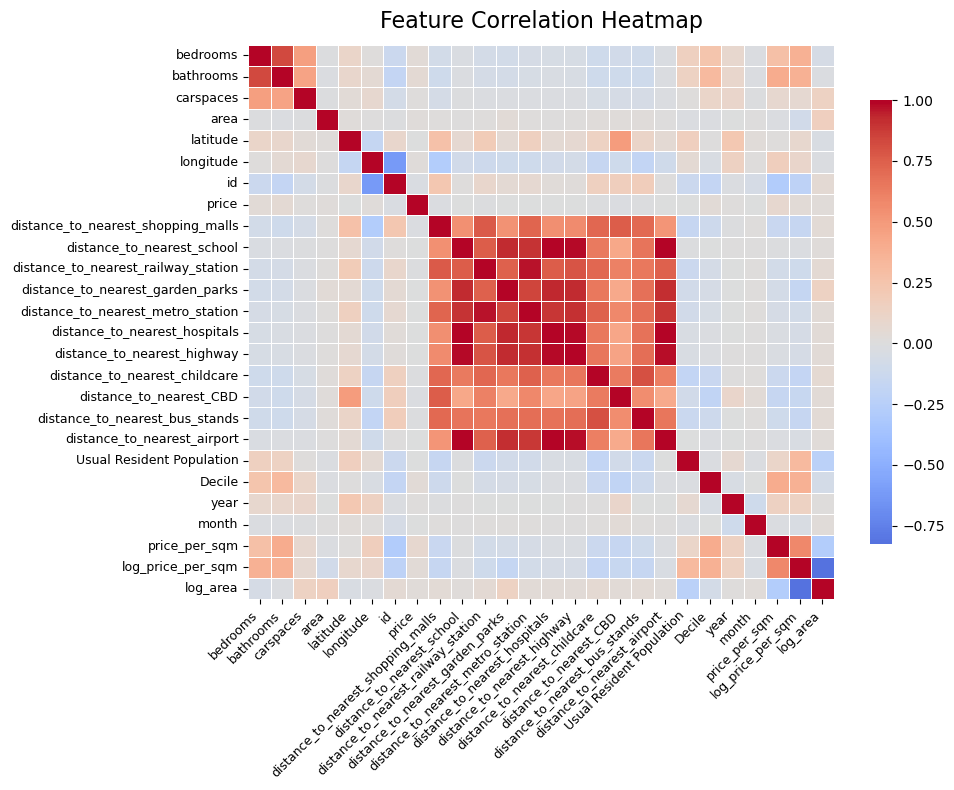

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix on original dataframe with target 'price'
corr_matrix_original = df.corr(numeric_only=True)  # Ensure only numeric columns

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix_original,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    annot=False,     # Show correlation values in cells
    fmt=".2f",      # Format annotations to 2 decimals
    cbar_kws={"shrink": 0.8}
)

plt.title("Feature Correlation Heatmap", fontsize=16, pad=12)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()


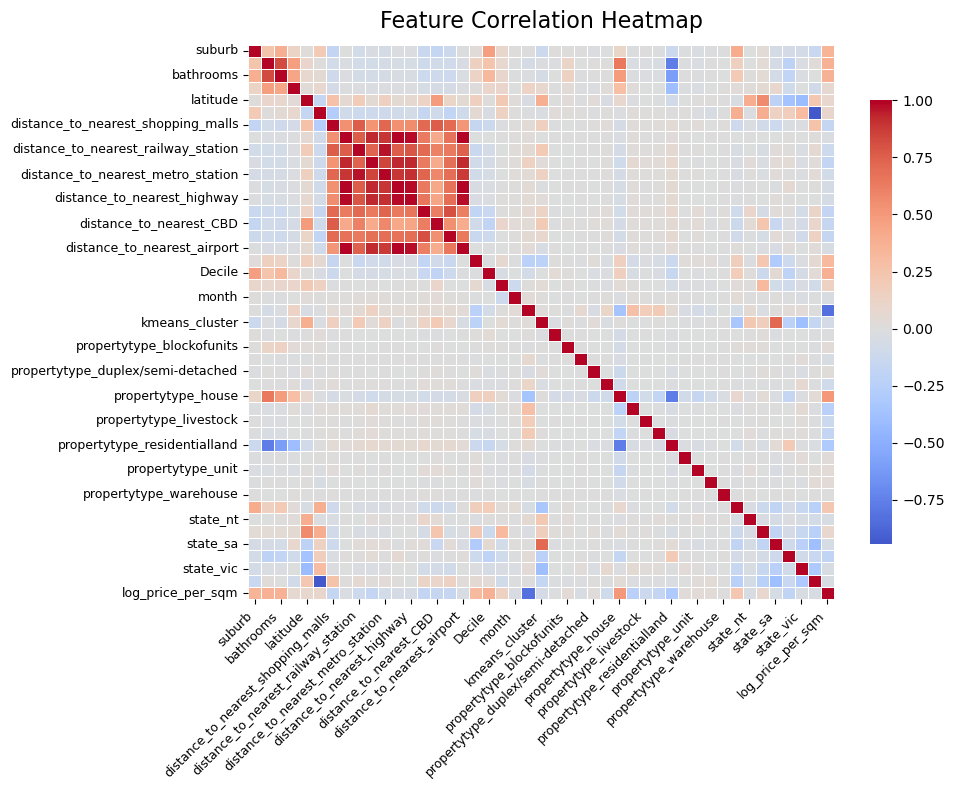

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Temporarily merge target back
X_train_with_target = X_train_full.copy()
X_train_with_target["log_price_per_sqm"] = y_train_full

# Compute full correlation matrix
corr_matrix = X_train_with_target.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    annot=False,
    cbar_kws={"shrink": 0.8}
)

plt.title("Feature Correlation Heatmap", fontsize=16, pad=12)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()


In [18]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd

# Reverse log transformation
actual_prices = np.expm1(y_test)
predicted_prices = np.expm1(y_pred)

# Residuals in original scale
residuals = predicted_prices - actual_prices

# Create DataFrame
results_df = pd.DataFrame({
    'Actual': actual_prices,
    'Predicted': predicted_prices,
    'Residual': residuals
})

# Scatter plot on original scale
fig = px.scatter(
    results_df,
    x='Actual',
    y='Predicted',
    color='Residual',
    color_continuous_scale='plasma',
    title='Actual vs Predicted Property Prices - XGBoost',
    labels={'Actual': 'Actual Price per SQM area', 'Predicted': 'Predicted Price per SQM area'}
)

# Add perfect prediction line
min_val = results_df[['Actual', 'Predicted']].min().min()
max_val = results_df[['Actual', 'Predicted']].max().max()
fig.add_trace(go.Scatter(
    x=[min_val, max_val],
    y=[min_val, max_val],
    mode='lines',
    name='Perfect Prediction Line',
    line=dict(color='red', dash='dash')
))

# Layout adjustments
fig.update_layout(
    width=700,
    height=600,
    plot_bgcolor='rgba(240, 240, 240, 1)',
    paper_bgcolor='white',
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)

fig.show()


In [85]:
joblib.dump(X_train_full.columns.tolist(), "feature_columns.pkl")  # feature list
joblib.dump(scaler, "scaler.pkl")                                  # scaler
joblib.dump(kmeans, "kmeans_model.pkl")                             # KMeans
joblib.dump({
    "smoothed": full_stats["smoothed"],
    "global_mean": global_mean
}, "suburb_stats.pkl")                                              # suburb encoding
joblib.dump(best_model, "xgb_model.pkl")                            # XGBoost model


['xgb_model.pkl']

In [99]:
import pandas as pd
import numpy as np
import joblib

# Load saved artifacts
model = joblib.load("xgb_model.pkl")
scaler = joblib.load("scaler.pkl")
kmeans = joblib.load("kmeans_model.pkl")
feature_columns = joblib.load("feature_columns.pkl")
suburb_encoding = pd.read_csv("suburb_encoding.csv", index_col=0)

# Load new data
new_df = pd.read_csv("Test_data.csv")
# Log area
new_df["log_area"] = np.log1p(new_df["area"])
# Drop unnecessary columns
drop_cols = ["property_id", "street", "streetnumber", "Score", "postcode",
             "area", "id", "price", "price_per_sqm", "streettype", "log_price_per_sqm"]
new_df.drop(columns=[col for col in drop_cols if col in new_df.columns], inplace=True)

# Handle missing values
new_df.dropna(subset=["latitude", "longitude", "suburb"], inplace=True)

# Date features
new_df["date"] = pd.to_datetime(new_df["date"], errors='coerce')
new_df["year"] = new_df["date"].dt.year
new_df["month"] = new_df["date"].dt.month
new_df.drop(columns=["date"], inplace=True)



# Encode suburb using saved encoding
new_df["suburb"] = new_df["suburb"].map(suburb_encoding["smoothed"]).fillna(suburb_encoding["smoothed"].mean())

# KMeans clustering
new_df["kmeans_cluster"] = kmeans.predict(new_df[["latitude", "longitude"]])

# One-hot encode
new_df = pd.get_dummies(new_df, columns=["propertytype", "state"], drop_first=True, dtype=int)

# Align features with training data
for col in feature_columns:
    if col not in new_df.columns:
        new_df[col] = 0
new_df = new_df[feature_columns]  # exact same column order

# Scale features
X_new_scaled = scaler.transform(new_df)

# Predict log price per sqm
log_price_per_sqm_pred = model.predict(X_new_scaled)

# Estimate area again (in case you need predicted total price)
area = np.expm1(new_df["log_area"])
predicted_price_per_sqm = np.expm1(log_price_per_sqm_pred)
predicted_price = predicted_price_per_sqm * area

# Create output
results = pd.DataFrame({
    "predicted_log_price_per_sqm": log_price_per_sqm_pred,
    "predicted_price_per_sqm": predicted_price_per_sqm,
    "predicted_price": predicted_price
})

# Save to CSV
results.to_csv("predicted_prices.csv", index=False)
print("✅ Predictions saved to 'predicted_prices.csv'")


✅ Predictions saved to 'predicted_prices.csv'


C:\Users\Admin\AppData\Local\Temp\ipykernel_3992\2130008337.py:25: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  new_df["date"] = pd.to_datetime(new_df["date"], errors='coerce')


In [101]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Load the dataset
data = pd.read_csv('predicted_prices.csv')


# Extract actual and predicted prices
actual = data['actual_price']
predicted = data['predicted_price']

# Calculate metrics
mae = mean_absolute_error(actual, predicted)
mape = np.mean(np.abs((actual - predicted) / actual)) * 100
rmse = np.sqrt(mean_squared_error(actual, predicted))
r2 = r2_score(actual, predicted)

# Print results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 44314.920038535645
Mean Absolute Percentage Error (MAPE): 8.532889735765723%
Root Mean Squared Error (RMSE): 52255.15181041894
R-squared (R²): 0.968431713970666


In [ ]:
# normal. without price/area.

In [16]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [17]:
###############################################
# train.py: Training and artifact serialization
###############################################


# 1. Load and preprocess data
df = pd.read_csv("Train_data.csv")
# Drop unneeded columns
drop_cols = ["property_id","street","streetnumber","Score","postcode","id","streettype"]
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)
# Remove rows with critical missing values
df.dropna(subset=["price","area","latitude","longitude","suburb","date"], inplace=True)
# Date features
df["date"] = pd.to_datetime(df["date"], errors='coerce')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df.drop(columns=['date'], inplace=True)
# Feature transforms
df['log_area'] = np.log1p(df['area'])
df['log_price'] = np.log1p(df['price'])

# 2. Define features and target
drop_for_X = ['price','area','log_price']
X = df.drop(columns=drop_for_X)
y = df['log_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Cross-validated target encoding for 'suburb' on log_price
global_mean = y_train.mean()
alpha = 10
kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_enc = pd.Series(index=X_train.index, dtype=float)
X_train_enc = X_train.copy()
X_train_enc['log_price'] = y_train
for tr_idx, val_idx in kf.split(X_train_enc):
    tr_fold = X_train_enc.iloc[tr_idx]
    val_fold = X_train_enc.iloc[val_idx]
    stats = tr_fold.groupby('suburb')['log_price'].agg(['mean','count'])
    stats['smoothed'] = (stats['mean']*stats['count'] + global_mean*alpha) / (stats['count'] + alpha)
    train_enc.iloc[val_idx] = val_fold['suburb'].map(stats['smoothed'])
X_train['suburb_enc'] = train_enc

# Statistics on full train for inference
full_stats = X_train_enc.groupby('suburb')['log_price'].agg(['mean','count'])
full_stats['smoothed'] = (full_stats['mean']*full_stats['count'] + global_mean*alpha) / (full_stats['count'] + alpha)
X_test['suburb_enc'] = X_test['suburb'].map(full_stats['smoothed']).fillna(global_mean)

# 4. Spatial clustering
coords = ['latitude','longitude']
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
X_train['cluster'] = kmeans.fit_predict(X_train[coords])
X_test['cluster'] = kmeans.predict(X_test[coords])

# 5. Drop raw/unneeded features
to_drop = ['suburb','area','price_per_sqm','log_price']
X_train.drop(columns=[c for c in to_drop if c in X_train.columns], inplace=True)
X_test.drop(columns=[c for c in to_drop if c in X_test.columns], inplace=True)

# 6. Categorical encoding & alignment
X_train = pd.get_dummies(X_train, columns=['propertytype','state'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['propertytype','state'], drop_first=True)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# 7. Feature scaling
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# 8. Train XGBoost on log_price target
params = {
    'n_estimators': 1000,
    'learning_rate': 0.0545,
    'max_depth': 9,
    'reg_alpha': 0.6279,
    'reg_lambda': 0.1943,
    'subsample': 0.6284,
    'colsample_bytree': 0.8058,
    'random_state': 42
}
model = xgb.XGBRegressor(**params)
model.fit(X_train_sc, y_train)

# 9. Evaluate on test
# Log-space metrics
y_pred_log = model.predict(X_test_sc)
mae_log = mean_absolute_error(y_test, y_pred_log)
mse_log = mean_squared_error(y_test, y_pred_log)
r2_log = r2_score(y_test, y_pred_log)
# Bias correction factor (error variance)
sigma2 = mse_log

print("--- Log-space results ---")
print(f"MAE (log1p price): {mae_log:.4f}")
print(f"RMSE (log1p price): {np.sqrt(mse_log):.4f}")
print(f"R^2 (log-space): {r2_log:.4f}")

# Price-space metrics with bias correction
price_pred = np.expm1(y_pred_log + sigma2/2)
true_price = df.loc[X_test.index, 'price']
mae_p = mean_absolute_error(true_price, price_pred)
rmse_p = np.sqrt(mean_squared_error(true_price, price_pred))
r2_p = r2_score(true_price, price_pred)

print("--- Price-space results ---")
print(f"MAE (price): {mae_p:.2f}")
print(f"RMSE (price): {rmse_p:.2f}")
print(f"R^2 (price): {r2_p:.4f}")

C:\Users\DIVYA\AppData\Local\Temp\ipykernel_18952\1208129192.py:14: UserWarning:

Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



--- Log-space results ---
MAE (log1p price): 0.1856
RMSE (log1p price): 0.2894
R^2 (log-space): 0.9158
--- Price-space results ---
MAE (price): 179834.78
RMSE (price): 704499.23
R^2 (price): 0.7481


In [ ]:
# 10. Save artifacts
joblib.dump(model, 'xgb_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump({'smoothed': full_stats['smoothed'], 'global_mean': global_mean, 'sigma2': sigma2}, 'suburb_stats.pkl')
joblib.dump(list(X_train.columns), 'feature_columns.pkl')

['feature_columns.pkl']

In [23]:
###############################################
# predict.py: Inference on new data
###############################################
import pandas as pd
import numpy as np
import joblib

def predict_prices(test_csv, out_csv):
    # Load artifacts
    model = joblib.load('xgb_model.pkl')
    scaler = joblib.load('scaler.pkl')
    kmeans = joblib.load('kmeans_model.pkl')
    stats = joblib.load('suburb_stats.pkl')
    feat_cols = joblib.load('feature_columns.pkl')

    nd = pd.read_csv(test_csv)
    nd.dropna(subset=['price','area','latitude','longitude','suburb','date'], inplace=True)
    nd['date'] = pd.to_datetime(nd['date'], errors='coerce')
    nd['year'] = nd['date'].dt.year
    nd['month'] = nd['date'].dt.month
    nd['log_area'] = np.log1p(nd['area'])

    # Suburb encoding
    nd['suburb_enc'] = nd['suburb'].map(stats['smoothed']).fillna(stats['global_mean'])
    # Clustering
    nd['cluster'] = kmeans.predict(nd[['latitude','longitude']])

    # Drop unused
    drop_cols = ['property_id','street','streetnumber','Score','postcode',
                 'price','area','date','suburb',"streettype"]
    nd.drop(columns=[c for c in drop_cols if c in nd.columns], inplace=True)

    # One-hot & align
    nd = pd.get_dummies(nd, columns=['propertytype','state'], drop_first=True)
    for c in feat_cols:
        if c not in nd.columns:
            nd[c] = 0
    nd = nd[feat_cols]

    # Scale & predict
    Xn = scaler.transform(nd)
    y_pred_log = model.predict(Xn)
    price_pred = np.expm1(y_pred_log + stats['sigma2']/2)

    results = pd.DataFrame({
        'predicted_log_price': y_pred_log,
        'predicted_price': price_pred
    })
    results.to_csv(out_csv, index=False)
    print(f"✅ Predictions saved to {out_csv}")

if __name__ == '__main__':
    predict_prices('Test_data.csv','predicted_prices.csv')


✅ Predictions saved to predicted_prices.csv


C:\Users\DIVYA\AppData\Local\Temp\ipykernel_18952\767281824.py:18: UserWarning:

Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.

